<a href="https://colab.research.google.com/github/VeberV/Data_dash/blob/main/HW_2_Veber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Импорт библиотек**

In [4]:
import requests
from bs4 import BeautifulSoup
import re

import os
import glob

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # для qq plot

from scipy.stats import shapiro # тест на нормальность распределения Шапиро
from scipy.stats import normaltest # тест на нормальность распределения Деагостино
from scipy.stats import mannwhitneyu # тест Манна-Уитни непараметрический тест
from scipy.stats import ttest_ind # t-тест
from statsmodels.stats.weightstats import ztest # z-тест
from scipy.stats import kruskal
from scipy import stats # библиотека для расчетов
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

**Загрузка файлов из репозитория**

In [5]:
import requests
from bs4 import BeautifulSoup
import re
import os

# URL репозитория
repo_url = 'https://github.com/JeffSackmann/tennis_atp'

# Папка, в которой находятся файлы
folder_path = 'blob/master/'

# Директория для сохранения файлов
save_dir = 'github_data'

# Создаем директорию, если она не существует
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Создаем сессию requests
with requests.Session() as session:
    # Получаем страницу репозитория с файлами
    response = session.get(f'{repo_url}/{folder_path}')
    if response.ok:
        # Используем BeautifulSoup для парсинга HTML
        soup = BeautifulSoup(response.text, 'html.parser')

        # Ищем все ссылки на csv файлы, которые соответствуют маске
        regex = re.compile(r'atp_matches_\d{4}\.csv')
        for a in soup.find_all('a', href=True):
            if regex.match(a.text):
                # Строим URL файла
                file_url = f'https://github.com{a["href"]}'
                # Превращаем ссылку на просмотр в ссылку на скачивание
                raw_url = file_url.replace('/blob/', '/raw/')
                # Скачиваем файл
                file_response = session.get(raw_url)
                if file_response.ok:
                    # Сохраняем содержимое файла
                    file_name = os.path.join(save_dir, a.text)
                    with open(file_name, 'wb') as file:
                        file.write(file_response.content)
                        print(f'Downloaded {file_name}')
                else:
                    print(f'Failed to download {a.text}')
    else:
        print('Failed to retrieve the repository page')

Downloaded github_data/atp_matches_1968.csv
Downloaded github_data/atp_matches_1968.csv
Downloaded github_data/atp_matches_1969.csv
Downloaded github_data/atp_matches_1969.csv
Downloaded github_data/atp_matches_1970.csv
Downloaded github_data/atp_matches_1970.csv
Downloaded github_data/atp_matches_1971.csv
Downloaded github_data/atp_matches_1971.csv
Downloaded github_data/atp_matches_1972.csv
Downloaded github_data/atp_matches_1972.csv
Downloaded github_data/atp_matches_1973.csv
Downloaded github_data/atp_matches_1973.csv
Downloaded github_data/atp_matches_1974.csv
Downloaded github_data/atp_matches_1974.csv
Downloaded github_data/atp_matches_1975.csv
Downloaded github_data/atp_matches_1975.csv
Downloaded github_data/atp_matches_1976.csv
Downloaded github_data/atp_matches_1976.csv
Downloaded github_data/atp_matches_1977.csv
Downloaded github_data/atp_matches_1977.csv
Downloaded github_data/atp_matches_1978.csv
Downloaded github_data/atp_matches_1978.csv
Downloaded github_data/atp_match

In [11]:
!pwd

/content


**Сборка датасетов в датафрейм**

In [13]:


# Указываем путь к папке с данными
folder_path = 'github_data'  # Укажи актуальный путь

# Получаем список всех CSV файлов, соответствующих маске 'atp_matches_*.csv'
csv_files = glob.glob(os.path.join(folder_path, 'atp_matches_*.csv'))

# Читаем каждый CSV файл и добавляем его в список датафреймов
df_list = [pd.read_csv(file) for file in csv_files]

# Объединяем все датафреймы в один, игнорируя индексы и используя внешнее объединение
combined_df = pd.concat(df_list, ignore_index=True, join='outer')

# Извлекаем год из столбца tourney_id и преобразуем его в целочисленный тип
combined_df['year'] = combined_df['tourney_id'].str.extract(r'(\d{4})').astype(int)

# Сохраняем объединенный датафрейм в файл 'C:\Курс DS - 3\IDE/full_data/combined_atp_matches.csv' без индексов
combined_df.to_csv('/content/combined_atp_matches.csv', index=False)


In [14]:
combined_df = pd.read_csv('/content/combined_atp_matches.csv')

In [15]:
combined_df.shape

(191920, 50)


**Функции для предобработки**

In [16]:
def df_info(df):
    """
    Функция для получения информации о датафрейме.

    Args:
        df (pandas.DataFrame): Входной датафрейм.

    Returns:
        None
    """
    len_df = len(df)
    count = 0
    na_col_name = []
    na_col_size = []
    unique_list = []

    for col in df.columns:
        notnull = df[col].notna().sum()
        if notnull < len_df:
            count += 1
        if df[col].isna().sum() > 0:
            na_col_name.append(col)
            col_size = df[col].isna().sum() / len(df) * 100
            na_col_size.append(col_size)

        unique_list.append(len(df[col].unique()))

    pivot = pd.DataFrame(data=unique_list, index=df.columns, columns=['Уникальные значения'])

    print(f'Количество записей: \t {len_df}')
    print(f'Количество столбцов: \t {len(df.columns)}')
    print(f'Явных дубликатов: \t {df.duplicated().sum()}')
    print(f'Пропуски присутствуют в {count} столбцах из {len(df.columns)}:')
    display(pd.DataFrame(na_col_size, index=na_col_name, columns=['Пропущено %']).sort_values(by='Пропущено %', ascending=False))
    print('Обобщенная информация:')
    display(df.info(verbose=False))
    print('Первые 3 строки:')
    display(df.head(3))

In [17]:
def low_information_features(df):
    """
    Функция для определения неинформативных признаков в датафрейме.

    Признаки считаются неинформативными, если одно значение встречается более чем в 95%
    случаев или если более 95% значений являются уникальными.

    Args:
        df (pandas.DataFrame): Входной датафрейм.

    Returns:
        Union[list, str]: Список неинформативных признаков или сообщение об их отсутствии.
    """
    low_information_cols = []  # инициализация списка для неинформативных признаков

    for col in df.columns:  # цикл по всем столбцам
        top_freq = df[col].value_counts(normalize=True).max()  # наибольшая относительная частота в признаке
        nunique_ratio = df[col].nunique() / df[col].count()  # доля уникальных значений от размера признака

        # сравниваем наибольшую частоту с порогом 95%
        if top_freq > 0.95:
            low_information_cols.append(col)  # добавляем столбец в список
            # выводим информацию о признаке
            print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')

        # сравниваем долю уникальных значений с порогом 95%
        if nunique_ratio > 0.95:
            low_information_cols.append(col)  # добавляем столбец в список
            # выводим информацию о признаке
            print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

    if not low_information_cols:
        return "Нет неинформативных признаков"
    else:
        return low_information_cols  # возвращаем список неинформативных признаков

In [18]:
def plot_missing_values(df):
    """
    Функция для построения столбчатой диаграммы, отображающей процент пропущенных значений в каждом столбце датафрейма.

    Args:
        df (pandas.DataFrame): Входной датафрейм.

    Returns:
        None
    """
    # Вычисление процента пропущенных значений
    nans = 100 * df.isnull().mean().sort_values(ascending=False)[df.isnull().mean().sort_values(ascending=False) > 0]

    # Построение столбчатой диаграммы
    nans.plot(
        kind='bar',
        logy=False,
        figsize=(10,5),
        title='Соотношение пропусков, %'
    )

**Функции для графического описания**

In [19]:
def plot_sample_data(sample_data_a, sample_data_b, title_a='a', title_b='b'):
    """
    Функция для создания графиков QQ, гистограмм и boxplot для двух выборок.

    Args:
    sample_data_a: Первая выборка данных
    sample_data_b: Вторая выборка данных
    title_a: Название для первой выборки
    title_b: Название для второй выборки
    """
    fig, axs = plt.subplots(3, 2, figsize=(10, 15))
    plt.subplots_adjust(hspace=0.5)

    # Создание графика QQ-графика для sample_data_a
    # sm.qqplot(sample_data_a, line='45', ax=axs[0, 0])
    stats.probplot(sample_data_a, plot=axs[0, 0]) # qq plot
    axs[0, 0].set_title(f'График QQ для {title_a}')

    # Создание графика QQ-графика для sample_data_b
    # sm.qqplot(sample_data_b, line='45', ax=axs[0, 1])
    stats.probplot(sample_data_b, plot=axs[0, 1]) # qq plot
    axs[0, 1].set_title(f'График QQ для {title_b}')

    # Создание гистограммы для sample_data_a
    sns.histplot(sample_data_a, kde=True, ax=axs[1, 0])
    axs[1, 0].set_title(f'Гистограмма для {title_a}')

    # Создание гистограммы для sample_data_b
    sns.histplot(sample_data_b, kde=True, ax=axs[1, 1])
    axs[1, 1].set_title(f'Гистограмма для {title_b}')

    # Создание графика boxplot для sample_data_a с отрисовкой среднего и медианы
    sns.boxplot(sample_data_a, ax=axs[2, 0], showmeans=True, meanline=True, showfliers=False)
    axs[2, 0].set_title(f'Boxplot для {title_a} \n mean: {np.mean(sample_data_a):.2f}, median: {np.median(sample_data_a):.2f}')

    # Создание графика boxplot для sample_data_b с отрисовкой среднего и медианы
    sns.boxplot(sample_data_b, ax=axs[2, 1], showmeans=True, meanline=True, showfliers=False)
    axs[2, 1].set_title(f'Boxplot для {title_b} \n mean: {np.mean(sample_data_b):.2f}, median: {np.median(sample_data_b):.2f}')

    plt.show()

**Тест Шапиро**

In [20]:
def shapiro_test(sample_a, sample_b, alpha=0.05):
    H0 = 'Распределения в обеих группах нормальные'
    H1 = 'Распределение в одной или обеих группах отлично от нормального'

    shapiro_result_a = shapiro(sample_a)
    shapiro_result_b = shapiro(sample_b)

    print(f'alpha: {alpha}')
    print('p-value sample A', round(shapiro_result_a.pvalue, 2))
    print('p-value sample B', round(shapiro_result_b.pvalue, 2))

    if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
        print("Отвергаем нулевую гипотезу H0: {}".format(H0))
        print("Альтернативная гипотеза. H1: {}".format(H1))
    else:
        print("Принимаем нулевую гипотезу. {}".format(H0))

# Пример использования:
# shapiro_test(more20['deviation'], less20['deviation'], alpha=0.05)

In [21]:
low_information_features(combined_df)

'Нет неинформативных признаков'

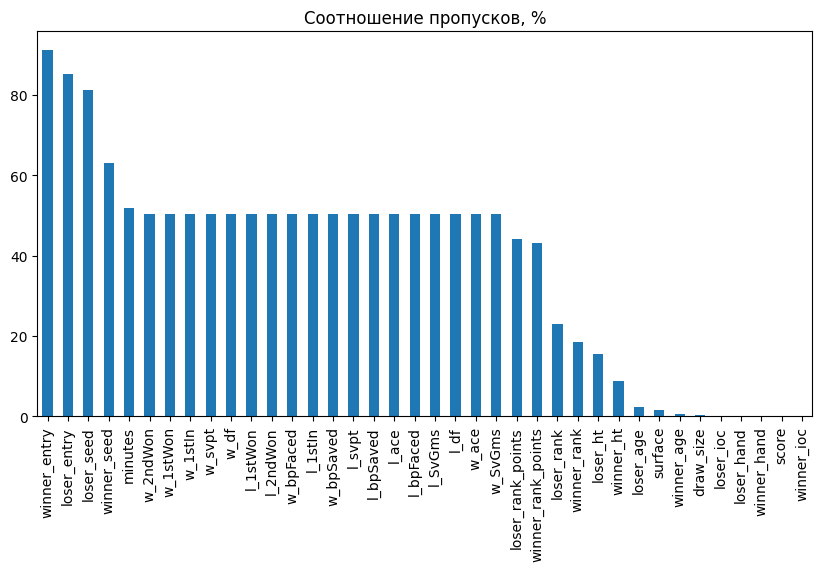

In [22]:
plot_missing_values(combined_df)

In [23]:
# удаляем столбец если у него 60% или более значений отсутствует
combined_df = combined_df.dropna(axis=1, thresh=(0.4 * combined_df.shape[0]))

In [24]:
# Общий обзор сборного датасета
df_info(combined_df)

Количество записей: 	 191920
Количество столбцов: 	 46
Явных дубликатов: 	 0
Пропуски присутствуют в 34 столбцах из 46:


,Пропущено %
minutes,51.924239
w_2ndWon,50.482493
w_1stIn,50.482493
l_bpFaced,50.482493
l_bpSaved,50.482493
w_bpFaced,50.482493
l_2ndWon,50.482493
l_1stWon,50.482493
l_1stIn,50.482493
l_svpt,50.482493


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191920 entries, 0 to 191919
Columns: 46 entries, tourney_id to year
dtypes: float64(28), int64(6), object(12)
memory usage: 67.4+ MB


None

Первые 3 строки:


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,1988-201,Guaruja,Hard,32.0,A,19880125,1,100586,Eliot Teltscher,R,...,NaN,NaN,NaN,NaN,NaN,22.0,NaN,251.0,NaN,1988
1,1988-201,Guaruja,Hard,32.0,A,19880125,2,101133,Patrick Baur,R,...,NaN,NaN,NaN,NaN,NaN,182.0,NaN,317.0,NaN,1988
2,1988-201,Guaruja,Hard,32.0,A,19880125,3,100669,Charles Bud Cox,R,...,NaN,NaN,NaN,NaN,NaN,232.0,NaN,205.0,NaN,1988


## **Задача_01_а**



Если ранг игрока выше более, чем на 20 позиций, то в среднем он будет выигрывать с большей вероятностью. (Если хотите проверить статистически — формируйте выборку как отклонение от ожидаемого количества побед при случайном исходе);



### **Создание выборки к задаче **

In [26]:
# Создание выборки
combined_df = pd.read_csv('/content/combined_atp_matches.csv')
task_01_a = combined_df[['year', 'match_num', 'winner_id', 'winner_rank', 'loser_id', 'loser_rank']].dropna()
task_01_a['rank_diff_more20'] = np.where(abs(task_01_a['winner_rank'] - task_01_a['loser_rank']) > 20, 1, 0)

# Размеры выборок
task_01_a.rank_diff_more20.value_counts()

1    106767
0     37093
Name: rank_diff_more20, dtype: int64

In [27]:
df_info(task_01_a)

Количество записей: 	 143860
Количество столбцов: 	 7
Явных дубликатов: 	 57
Пропуски присутствуют в 0 столбцах из 7:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 143860 entries, 0 to 191919
Columns: 7 entries, year to rank_diff_more20
dtypes: float64(2), int64(5)
memory usage: 8.8 MB


None

Первые 3 строки:


,year,match_num,winner_id,winner_rank,loser_id,loser_rank,rank_diff_more20
0,1988,1,100586,22.0,100548,251.0,1
1,1988,2,101133,182.0,100986,317.0,1
2,1988,3,100669,232.0,101076,205.0,1


In [28]:
def calculate_player_performance_metrics(task_01_a):
   """
   Функция для расчёта метрик производительности игроков

   Parameters:
   task_01_a (DataFrame): DataFrame с информацией о победах и поражениях

   Returns:
   DataFrame: DataFrame с метриками производительности игроков
   """
   wins_count = task_01_a['winner_id'].value_counts()
   losses_count = task_01_a['loser_id'].value_counts()
   total_games = wins_count.add(losses_count, fill_value=0).astype(int)
   player_performance_df = pd.DataFrame({
       'player_id': total_games.index,
       'wins': wins_count,
       'losses': losses_count,
       'total': total_games
   }).reset_index(drop=True)
   player_performance_df['wins'].fillna(0, inplace=True)
   player_performance_df['losses'].fillna(0, inplace=True)
   player_performance_df['wins'] = player_performance_df['wins'].astype(int)
   player_performance_df['losses'] = player_performance_df['losses'].astype(int)
   player_performance_df['expected_wins'] = player_performance_df['total'] * 0.5
   player_performance_df['deviation'] = player_performance_df['wins'] - player_performance_df['expected_wins']
   return player_performance_df.sort_values(by='total', ascending=False)

In [29]:
more20 = calculate_player_performance_metrics(task_01_a[task_01_a['rank_diff_more20'] == 1])
less20 = calculate_player_performance_metrics(task_01_a[task_01_a['rank_diff_more20'] == 0])


In [30]:
more20.head(3)

,player_id,wins,losses,total,expected_wins,deviation
2028,103819,821,103,924,462.0,359.0
2397,104745,694,88,782,391.0,303.0
1150,101736,614,132,746,373.0,241.0


In [31]:
less20.head(3)

,player_id,wins,losses,total,expected_wins,deviation
1157,103819,441,177,618,309.0,132.0
1330,104925,437,141,578,289.0,148.0
1306,104745,385,139,524,262.0,123.0


In [32]:
# Рассчитать среднее отклонение для каждой выборки
mean_dev_more20 = more20.deviation.abs().mean()
mean_dev_less20 = less20.deviation.abs().mean()

print(f'Cреднее отклонение для выборки more20: {round(mean_dev_more20, 2)}')
print(f'Cреднее отклонение для выборки less20: {round(mean_dev_less20, 2)}')


# Если в первой выборке (ранг выше более чем на 20 позиций) среднее отклонение значительно выше,
# чем во второй выборке, то это подтверждает гипотезу о
# большей вероятности выигрыша у игроков с более высоким рангом.

Cреднее отклонение для выборки more20: 7.23
Cреднее отклонение для выборки less20: 2.97


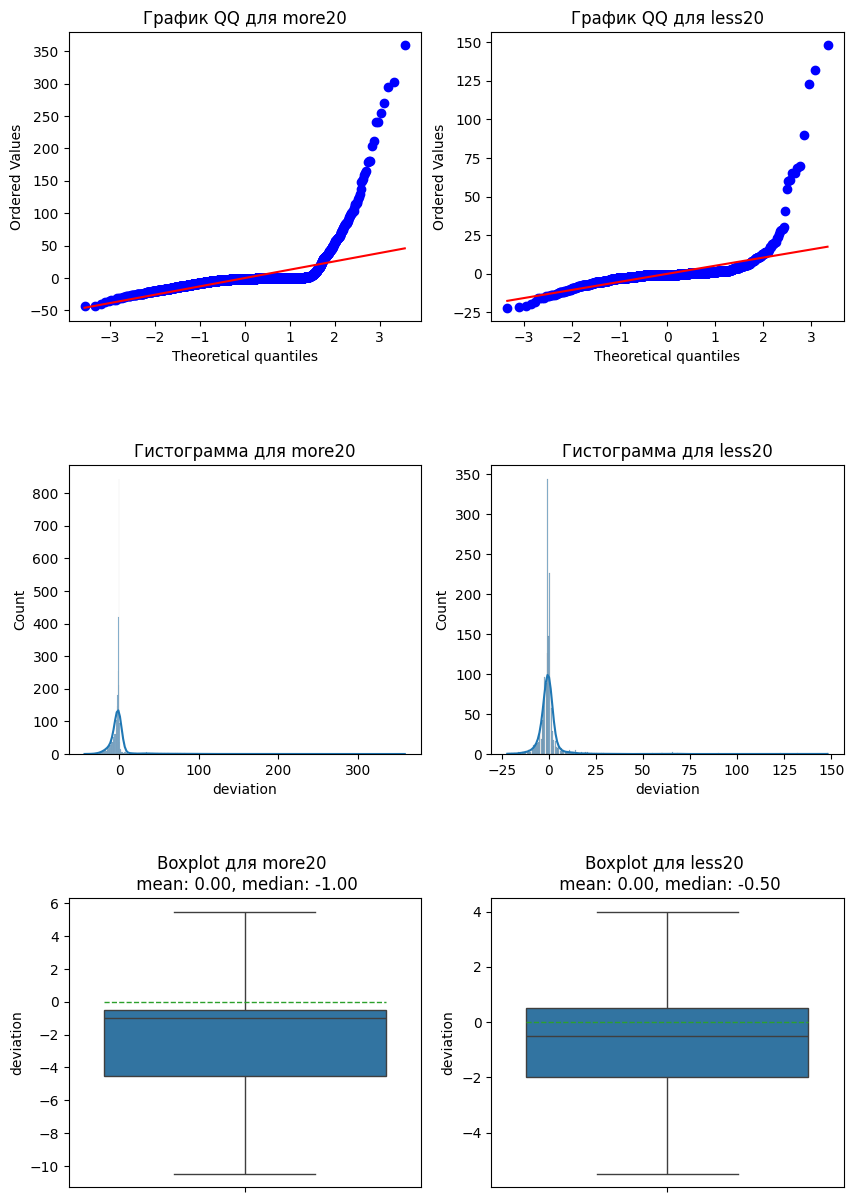

In [33]:
plot_sample_data(more20.deviation, less20.deviation, title_a='more20', title_b='less20')

**Тест Шапиро**

In [34]:
shapiro_test(more20.deviation, less20.deviation, alpha=0.05)

alpha: 0.05
p-value sample A 0.0
p-value sample B 0.0
Отвергаем нулевую гипотезу H0: Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


In [35]:
# Тест Мана-Уитни
sample_a = more20.deviation
sample_b = less20.deviation

# Уровень значимости
alpha = 0.05

# Проведение одностороннего U-теста Манна-Уитни
stat, p = mannwhitneyu(sample_a, sample_b, alternative='greater')

# Вывод результатов
print(f'U-статистика: {stat}')
print(f'p-значение: {p}')

# Формулировка гипотез
H0 = 'Среднее отклонений для more20 не больше медианы для выборки less20'
H1 = 'Среднее отклонений для more20 больше медианы для выборки less20'
print(f'Нулевая гипотеза (вероятность победы не выше в группе с разницей рангов >20):{H0}')
print(f'Альтернативная гипотеза (вероятность победы выше в группе с разницей рангов >20):{H1}')

# Сравнение p-значения с уровнем значимости
if p < alpha:
    print(f'Отвергаем нулевую гипотезу: {H0} при a = {alpha}.')
    print(f'Принимаем альтернативную гипотезу: {H1} при a = {alpha}.')
else:
    print(f'Не отвергаем нулевую гипотезу: {H0} при a = {alpha}.')

U-статистика: 2221913.5
p-значение: 1.0
Нулевая гипотеза (вероятность победы не выше в группе с разницей рангов >20):Среднее отклонений для more20 не больше медианы для выборки less20
Альтернативная гипотеза (вероятность победы выше в группе с разницей рангов >20):Среднее отклонений для more20 больше медианы для выборки less20
Не отвергаем нулевую гипотезу: Среднее отклонений для more20 не больше медианы для выборки less20 при a = 0.05.


Вывод:Среднее отклонений для more20 не больше медианы для выборки less20 при a = 0.05.

## **Задача_01_b**

 Если ранг игрока находится в окне +-5 позиций, то вероятность победы будет значительно отличаться от гипотезы из предыдущего случая. Для проверки статистической значимости выборку можно сделать как среднее по годам (например, с 1980 по 2022г.). Подумайте, как правильно сформировать репрезентативную выборку.

In [44]:
# Создание выборки к задаче
combined_df = pd.read_csv('/content/combined_atp_matches.csv')
task_01_b = combined_df[['year', 'match_num', 'winner_id', 'winner_rank', 'loser_id', 'loser_rank']].dropna()

# Создание бинарного признака window5, который указывает,
# попадает ли разница рангов в интервал [-5, 5]
task_01_b['window5'] = task_01_b.apply(
    lambda row: 'in' if -5 <= (row['winner_rank'] - row['loser_rank']) <= 5 else 'out',
    axis=1
)
# check
task_01_b.window5.value_counts()

out    133840
in      10020
Name: window5, dtype: int64

In [45]:
df_info(task_01_b)

Количество записей: 	 143860
Количество столбцов: 	 7
Явных дубликатов: 	 57
Пропуски присутствуют в 0 столбцах из 7:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 143860 entries, 0 to 191919
Columns: 7 entries, year to window5
dtypes: float64(2), int64(4), object(1)
memory usage: 8.8+ MB


None

Первые 3 строки:


,year,match_num,winner_id,winner_rank,loser_id,loser_rank,window5
0,1988,1,100586,22.0,100548,251.0,out
1,1988,2,101133,182.0,100986,317.0,out
2,1988,3,100669,232.0,101076,205.0,out


In [46]:
# Фильтрация записей с 1980 по 2022 год
filtered_df = task_01_b[(task_01_b['year'] >= 1984) & (task_01_b['year'] <= 2022)]

# Группировка по 'winner_id', 'year' и 'window5', подсчет количества побед
win_counts = filtered_df.groupby(['winner_id', 'year', 'window5']).size().reset_index(name='win_count')

# Считаем среднее количество побед
average_wins = win_counts.groupby(['year', 'window5'])['win_count'].mean().reset_index()

# Разделение среднего количества побед на группы 'in' и 'out'

average_wins_in = average_wins[average_wins['window5'] == 'in'].reset_index(drop=True)
average_wins_out = average_wins[average_wins['window5'] == 'out'].reset_index(drop=True)

In [47]:
win_counts.head(3)

,winner_id,year,window5,win_count
0,100119,1985,out,1
1,100144,1984,out,1
2,100144,1985,out,1


In [48]:
df_info(average_wins_in)

Количество записей: 	 39
Количество столбцов: 	 3
Явных дубликатов: 	 0
Пропуски присутствуют в 0 столбцах из 3:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Columns: 3 entries, year to win_count
dtypes: float64(1), int64(1), object(1)
memory usage: 1.0+ KB


None

Первые 3 строки:


,year,window5,win_count
0,1984,in,1.873563
1,1985,in,1.966292
2,1986,in,2.144330


In [49]:
df_info(average_wins_out)

Количество записей: 	 39
Количество столбцов: 	 3
Явных дубликатов: 	 0
Пропуски присутствуют в 0 столбцах из 3:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Columns: 3 entries, year to win_count
dtypes: float64(1), int64(1), object(1)
memory usage: 1.0+ KB


None

Первые 3 строки:


,year,window5,win_count
0,1984,out,9.740000
1,1985,out,10.194719
2,1986,out,9.925170


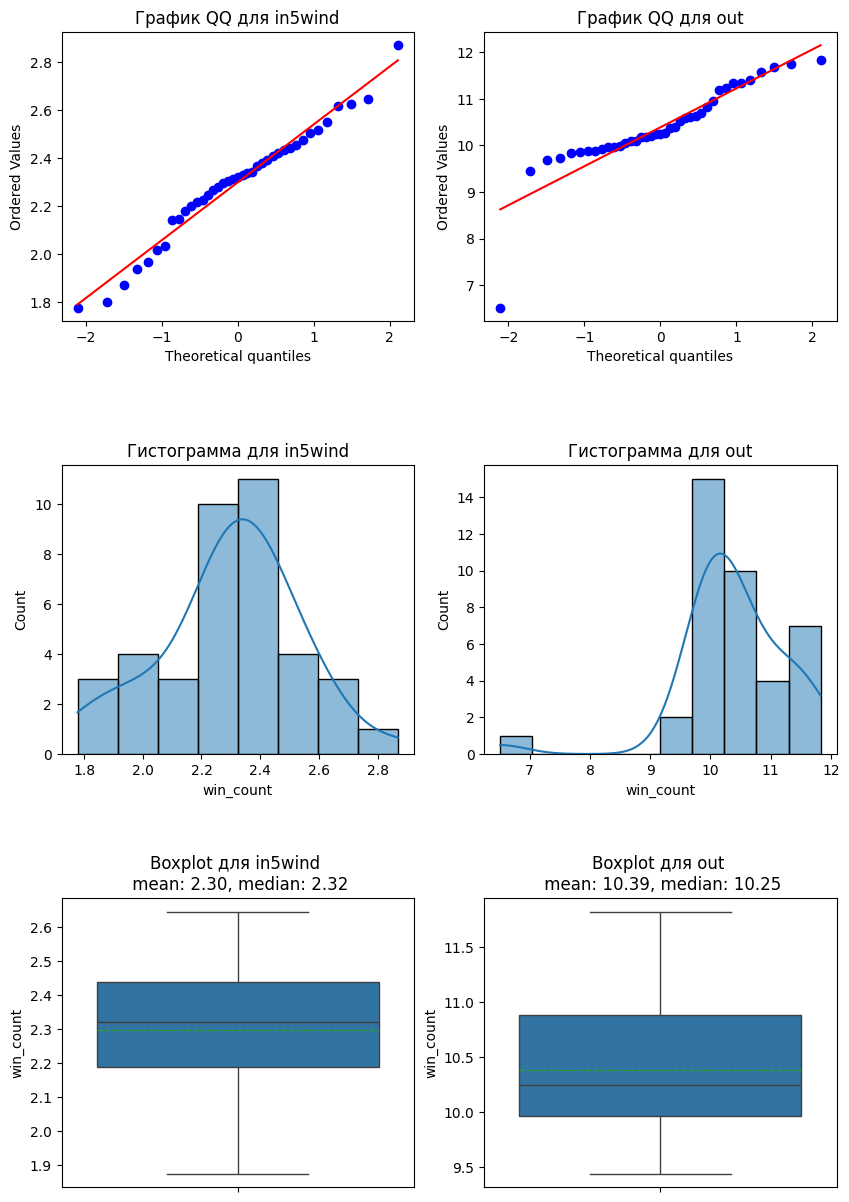

In [50]:
plot_sample_data(average_wins_in.win_count, average_wins_out.win_count, title_a='in5wind', title_b='out')

In [51]:
shapiro_test(average_wins_in.win_count, average_wins_out.win_count, alpha=0.05)

alpha: 0.05
p-value sample A 0.57
p-value sample B 0.0
Отвергаем нулевую гипотезу H0: Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


In [53]:
# Среднее количество побед в группе in5window
average_wins_in.win_count.mean()

2.299102049249689

In [54]:
# Среднее количество побед в группе out
average_wins_out.win_count.mean()

10.389651533600555

In [55]:
# Формулировка гипотез
H0 = 'Среднее количество побед в группе out не больше среднего в группе in'
H1 = 'Среднее количество побед в группе out больше среднего в группе in'

# Уровень значимости
alpha = 0.05

# Проведение одностороннего U-теста Манна-Уитни
stat, p = mannwhitneyu(average_wins_in.win_count, average_wins_out.win_count, alternative='less')

# Вывод результатов
print(f'U-статистика: {stat}')
print(f'p-значение: {p}')

# Сравнение p-значения с уровнем значимости
if p < alpha:
    print(f'Отвергаем нулевую гипотезу: {H0}')
    print(f'Принимаем альтернативную гипотезу: {H1}')
else:
    print(f'Принимаем нулевую гипотезу: {H0}')

U-статистика: 0.0
p-значение: 1.5393187778399125e-14
Отвергаем нулевую гипотезу: Среднее количество побед в группе out не больше среднего в группе in
Принимаем альтернативную гипотезу: Среднее количество побед в группе out больше среднего в группе in


Вывод:Если ранг игрока находится в окне +-5 позиций, то вероятность победы будет ниже чем в гипотезе из предыдущего случая. Для формирования репрезентативной выборки сделано усредненние побед всех игроков по годам.

## **Задача 02**

Правда ли, что среднее количество сетов, которое необходимо любому игроку для победы в матче, сокращается со временем? Разбейте данные на две группы — с 1980 до 2001 гг. и 2002-2022 гг. Как изменилось среднее количество сетов, которое победитель затратил на игру? Является ли разница средних этих двух выборок статистически значимой? Выбор статистического теста обоснуйте.

In [57]:
# Создание выборки к задаче
combined_df = pd.read_csv('/content/combined_atp_matches.csv')
task_02 = combined_df[['year', 'score', 'winner_id']].dropna()

# Создаем признак с количеством сетов
# Учитываем только те сеты при подсчете, где явно указан счет партии в сете
def count_sets_with_scores(score):
    sets = re.findall(r'\d+-\d+', score)
    return len(sets)

task_02['sets_count'] = task_02['score'].apply(count_sets_with_scores)

# Образец разбиения score на количество сетов
unique_sets_count = sorted(task_02['sets_count'].unique())
for count in unique_sets_count:
    print(f'Образец для количества сетов: {count}')
    display(task_02[task_02['sets_count'] == count].head(1))

df_info(task_02)

Образец для количества сетов: 0


,year,score,winner_id,sets_count
448,1988,W/O,101606,0


Образец для количества сетов: 1


,year,score,winner_id,sets_count
508,1988,6-6 RET,100282,1


Образец для количества сетов: 2


,year,score,winner_id,sets_count
0,1988,7-5 6-2,100586,2


Образец для количества сетов: 3


,year,score,winner_id,sets_count
7,1988,4-6 6-0 6-3,100800,3


Образец для количества сетов: 4


,year,score,winner_id,sets_count
637,1988,6-3 6-1 3-6 6-3,101142,4


Образец для количества сетов: 5


,year,score,winner_id,sets_count
731,1988,6-1 6-1 4-6 4-6 6-3,101426,5


Количество записей: 	 191911
Количество столбцов: 	 4
Явных дубликатов: 	 17938
Пропуски присутствуют в 0 столбцах из 4:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 191911 entries, 0 to 191919
Columns: 4 entries, year to sets_count
dtypes: int64(3), object(1)
memory usage: 7.3+ MB


None

Первые 3 строки:


,year,score,winner_id,sets_count
0,1988,7-5 6-2,100586,2
1,1988,7-5 6-4,101133,2
2,1988,6-2 6-4,100669,2


In [58]:
# Удаление полных дубликатов
task_02 = task_02.drop_duplicates()

# Образец разбиения score на количество сетов
unique_sets_count = sorted(task_02['sets_count'].unique())
for count in unique_sets_count:
    print(f'Образец для количества сетов: {count}')
    display(task_02[task_02['sets_count'] == count].head(1))

df_info(task_02)

Образец для количества сетов: 0


,year,score,winner_id,sets_count
448,1988,W/O,101606,0


Образец для количества сетов: 1


,year,score,winner_id,sets_count
508,1988,6-6 RET,100282,1


Образец для количества сетов: 2


,year,score,winner_id,sets_count
0,1988,7-5 6-2,100586,2


Образец для количества сетов: 3


,year,score,winner_id,sets_count
7,1988,4-6 6-0 6-3,100800,3


Образец для количества сетов: 4


,year,score,winner_id,sets_count
637,1988,6-3 6-1 3-6 6-3,101142,4


Образец для количества сетов: 5


,year,score,winner_id,sets_count
731,1988,6-1 6-1 4-6 4-6 6-3,101426,5


Количество записей: 	 173973
Количество столбцов: 	 4
Явных дубликатов: 	 0
Пропуски присутствуют в 0 столбцах из 4:


,Пропущено %


Обобщенная информация:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 173973 entries, 0 to 191919
Columns: 4 entries, year to sets_count
dtypes: int64(3), object(1)
memory usage: 6.6+ MB


None

Первые 3 строки:


,year,score,winner_id,sets_count
0,1988,7-5 6-2,100586,2
1,1988,7-5 6-4,101133,2
2,1988,6-2 6-4,100669,2


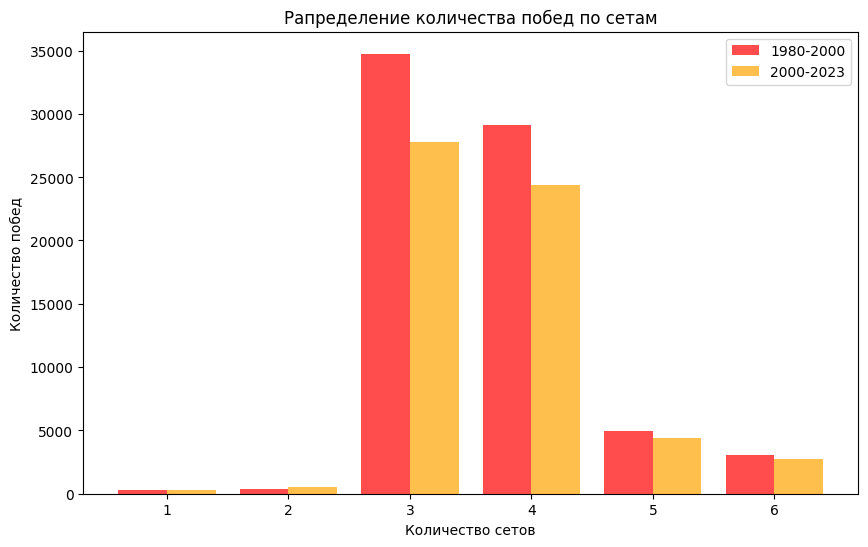

In [39]:
# Рапределение количества сетов, всего
# Фильтрация данных по годам
task_02_1980_2001 = task_02[(task_02['year'] >= 1980) & (task_02['year'] <= 2001)].reset_index(drop=True)
task_02_2002_2023 = task_02[(task_02['year'] > 2001) & (task_02['year'] <= 2023)].reset_index(drop=True)

# Создание позиций для баров
positions = range(1, max(task_02['sets_count']) + 2, 1)

# Построение гистограммы для каждой группы с разными цветами
plt.figure(figsize=(10, 6))
plt.bar([pos - 0.2 for pos in positions],
        task_02_1980_2001['sets_count'].value_counts().sort_index(),
        width=0.4,
        color='red',
        alpha=0.7,
        label='1980-2000')
plt.bar([pos + 0.2 for pos in positions],
        task_02_2002_2023['sets_count'].value_counts().sort_index(),
        width=0.4,
        color='orange',
        alpha=0.7,
        label='2000-2023')

plt.title('Рапределение количества побед по сетам')
plt.xlabel('Количество сетов')
plt.ylabel('Количество побед')
plt.legend()
plt.show()

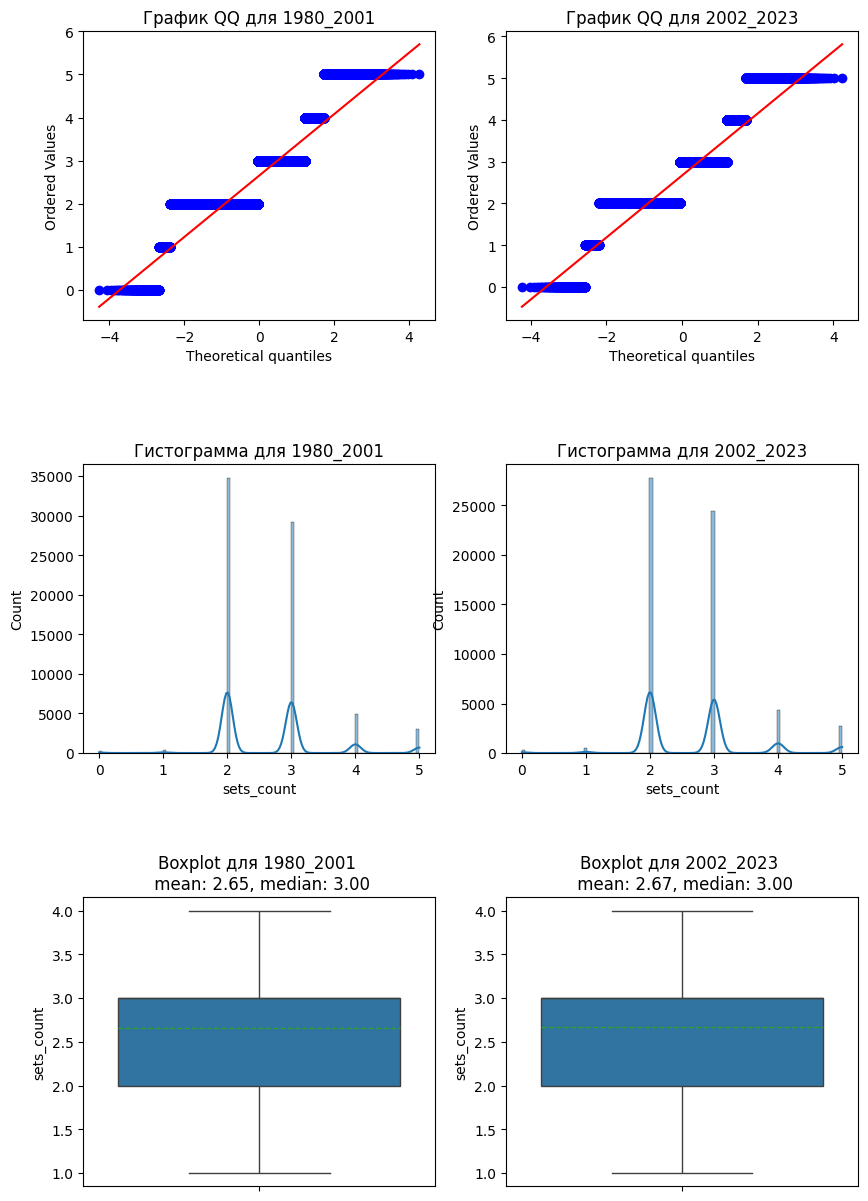

In [40]:
plot_sample_data(task_02_1980_2001.sets_count, task_02_2002_2023.sets_count, title_a='1980_2001', title_b='2002_2023')

In [41]:
# Сравнение среднего количества побед

print(f"Среднее количество сетов для побед в периоде 1980-2001: {task_02_1980_2001.sets_count.mean()}, общее количество партий: {len(task_02_1980_2001.sets_count)}")
print(f"Среднее количество сетов для побед в периоде 2002-2023: {task_02_2002_2023.sets_count.mean()}, общее количество партий: {len(task_02_2002_2023.sets_count)}")

Среднее количество сетов для побед в периоде 1980-2001: 2.6531740125141265, общее количество партий: 72558
Среднее количество сетов для побед в периоде 2002-2023: 2.668783561370551, общее количество партий: 60151


**Тест Шапиро**

In [42]:
shapiro_test(task_02_1980_2001.sets_count, task_02_2002_2023.sets_count, alpha=0.05)

alpha: 0.05
p-value sample A 0.0
p-value sample B 0.0
Отвергаем нулевую гипотезу H0: Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


**Z тест**

In [43]:
# Нулевая гипотеза: среднее значение первой выборки меньше или равно среднему значению второй выборки
# Альтернативная гипотеза: среднее значение первой выборки больше среднего значения второй выборки

# Проведем z-тест
z_stat, p_value = ztest(task_02_1980_2001.sets_count, task_02_2002_2023.sets_count, alternative='larger')

print(f'Z-statistic: {z_stat}')
print(f'P-value: {p_value}')

# Установим уровень значимости, например, 0.05
alpha = 0.05

# Проверим нулевую гипотезу
if p_value < alpha:
    print("Отвергаем нулевую гипотезу - есть достаточные доказательства, что среднее первой выборки 1980_2001 больше среднего второй 2002_2023")
else:
    print("Не отвергаем нулевую гипотезу - нет достаточных доказательств считать среднее первой выборки 1980_2001 большим")

Z-statistic: -3.4641509089513445
P-value: 0.999734045988888
Не отвергаем нулевую гипотезу - нет достаточных доказательств считать среднее первой выборки 1980_2001 большим


Вывод:Проведенный z тест позволяет утверждать - среднее значение первой выборки 1980_2001 меньше или равно среднему значению второй выборки 2002_2023.

Среднее количество сетов для любого игрока чтобы победить уменьшается со временем - не верно.